![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/training/english/classification/ClassifierDL_Training_using_INSTRUCTOR_Embeddings.ipynb)

# Training ClassifierDL with INSTRUCTOR Embeddings vs. Universal Sentence Encoder

Instructor👨‍🏫, an instruction-finetuned text embedding model that can generate text embeddings tailored to any task (e.g., classification, retrieval, clustering, text evaluation, etc.) and domains (e.g., science, finance, etc.) by simply providing the task instruction, without any finetuning. Instructor👨‍ achieves sota on 70 diverse embedding tasks.

**Setup**

In [ ]:
# Only run this cell when you are using Spark NLP on Google Colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2023-12-27 22:36:08--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2023-12-27 22:36:09--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Installing PySpark 3.2.3 and Spark NLP 5.2.1
setup Colab for PySpark 3.2.3 an

**Downloading classification dataset**

In [ ]:
!wget https://raw.githubusercontent.com/abdullahmubeen10/ClassifierDL_Training/main/test.csv
!wget https://raw.githubusercontent.com/abdullahmubeen10/ClassifierDL_Training/main/train.csv

--2023-12-27 22:37:44--  https://raw.githubusercontent.com/abdullahmubeen10/ClassifierDL_Training/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 749781 (732K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 732.21K  --.-KB/s    in 0.05s   

2023-12-27 22:37:44 (15.5 MB/s) - ‘test.csv’ saved [749781/749781]

--2023-12-27 22:37:44--  https://raw.githubusercontent.com/abdullahmubeen10/ClassifierDL_Training/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628989 (1.6M) [

In [ ]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version; ", spark.version)

Spark NLP version:  5.2.1
Apache Spark version;  3.2.3


In [ ]:
import pandas as pd

test_df = pd.read_csv('/content/test.csv')
train_df = pd.read_csv('/content/train.csv')

test_df.drop("Id", axis='columns', inplace=True)
train_df.drop("Id", axis='columns', inplace=True)

In [ ]:
train_df.head()

,Comment,Topic
0,A few things. You might have negative- frequen...,Biology
1,Is it so hard to believe that there exist part...,Physics
2,There are bees,Biology
3,I'm a medication technician. And that's alot o...,Biology
4,Cesium is such a pretty metal.,Chemistry


In [ ]:
print(f"(Train rows: {train_df.shape[0]} Test rows: {test_df.shape[0]})")

(Train rows: 8695 Test rows: 1586)


We are currently utilizing INSTRUCTOR Embeddings, which are built upon the T5 architecture and operate on a seq2seq model. Given their complexity, these embeddings are quite resource-intensive.
Processing our extensive dataset could be significantly time-consuming. Therefore, for demonstration purposes, let's reduce the size of the dataframe

Selecting unique values from the dataframe from the test and train data sets

In [ ]:
def sampled_df(original_df, column_name, rows_per_value):
    return original_df.groupby(column_name).apply(lambda x: x.sample(n=rows_per_value, replace=True)).reset_index(drop=True)

train_df = sampled_df(train_df, 'Topic', 500)
test_df = sampled_df(test_df, 'Topic', 100)

In [ ]:
print(f"(Train rows: {train_df.shape[0]} Test rows: {test_df.shape[0]})")

(Train rows: 1500 Test rows: 300)


Convert pandas DataFrame to Spark

In [ ]:
from pyspark.sql.functions import col

df_spark_train = spark.createDataFrame(train_df)
df_spark_test = spark.createDataFrame(test_df)

df_spark_train.show()

df_spark_train.groupBy("Topic") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+--------------------+-------+
|             Comment|  Topic|
+--------------------+-------+
|Wait im curious,,...|Biology|
|r/braindamageinac...|Biology|
|Ordinary burning ...|Biology|
|           [deleted]|Biology|
|She poses for me ...|Biology|
|Bury yourself und...|Biology|
|It’s bread. Wild ...|Biology|
|Thank you so much...|Biology|
|My best guess is ...|Biology|
|Friday Harbor, Wo...|Biology|
|Funny enough, I’m...|Biology|
|It's hard to have...|Biology|
|Getting the vacci...|Biology|
|You can tell by t...|Biology|
|so what are the m...|Biology|
|Looks like a bear...|Biology|
|See florida toe-b...|Biology|
|Maybe because ins...|Biology|
|Forbidden cotton ...|Biology|
|Welcome to the wo...|Biology|
+--------------------+-------+
only showing top 20 rows

+---------+-----+
|    Topic|count|
+---------+-----+
|Chemistry|  500|
|  Biology|  500|
|  Physics|  500|
+---------+-----+



In [ ]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [ ]:
documentAssembler = DocumentAssembler() \
    .setInputCol("Comment") \
    .setOutputCol("document")

embeddings = InstructorEmbeddings.pretrained() \
    .setInputCols(["document"]) \
    .setInstruction("Represent the sentences for categorical text classification: ") \
    .setOutputCol("instructor_embeddings")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["instructor_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("Topic")\
    .setMaxEpochs(20)\
    .setBatchSize(32)

pipeline = Pipeline().setStages([
     documentAssembler,
     embeddings,
     classsifierdl
 ])

instructor_base download started this may take some time.
Approximate size to download 387.7 MB
[OK!]


In [ ]:
%%time
pipelineModel = pipeline.fit(df_spark_train)

CPU times: user 5.71 s, sys: 648 ms, total: 6.36 s
Wall time: 17min 16s


# INSTRUCTOR Evaluation

Using classification_report from sklearn to evaluate the final scores.

In [ ]:
preds = pipelineModel.transform(df_spark_test)

In [ ]:
preds_df = preds.select('Topic','Comment',"class.result").toPandas()

**Exploding the array to get the results out.**
*They are currently inside a list [Biology] but we want them as a string Biology*

In [ ]:
preds_df['result'] = preds_df['result'].map({'P': 'Physics', 'B': 'Biology', 'C': 'Chemistry'}).eval('x[0]')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(preds_df['result'], preds_df['Topic'], zero_division=0))

              precision    recall  f1-score   support

     Biology       0.77      0.89      0.82        87
   Chemistry       0.82      0.78      0.80       105
     Physics       0.91      0.84      0.87       108

    accuracy                           0.83       300
   macro avg       0.83      0.84      0.83       300
weighted avg       0.84      0.83      0.83       300



# Training a new Classifier DL model *(using UniversalSentenceEncoder)* for comparision with INSTRUCTOR Embeddings



In [ ]:
documentAssembler = DocumentAssembler() \
    .setInputCol("Comment") \
    .setOutputCol("document")

USE_embeddings = UniversalSentenceEncoder.pretrained() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

classifier = ClassifierDLApproach() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("category") \
    .setLabelColumn("Topic") \
    .setMaxEpochs(20)\
    .setBatchSize(32)

USE_pipiline = Pipeline().setStages([
     documentAssembler,
     USE_embeddings,
     classifier
 ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
%%time
USE_pipelineModel = USE_pipiline.fit(df_spark_train)

CPU times: user 145 ms, sys: 16.6 ms, total: 161 ms
Wall time: 22 s


# USE *(UniversalSentenceEncoder)* Evaluation

Using classification_report from sklearn to evaluate the final scores.

In [ ]:
USE_preds = USE_pipelineModel.transform(df_spark_test)

In [ ]:
USE_preds_df = USE_preds.select('Topic','Comment',"category.result").toPandas()

**Exploding the array to get the results out.**
*They are currently inside a list [Biology] but we want them as a string Biology*

In [ ]:
USE_preds_df['result'] = USE_preds_df['result'].apply(lambda x : x[0])

mapping_dict = {'P': 'Physics', 'B': 'Biology', 'C': 'Chemistry'}
USE_preds_df['result'] = USE_preds_df['result'].replace(mapping_dict)

In [ ]:
USE_preds_df.head()

,Topic,Comment,result
0,Biology,So I take that as a No that if you put a suppl...,Chemistry
1,Biology,"No, cause you couldn’t reasonably claim non bi...",Biology
2,Biology,"Yes, and I agree with all of that. The values ...",Chemistry
3,Biology,AMINO ACID TRANSPORTERS\n SYSTEM ...,Chemistry
4,Biology,The same set of nine essential amino acids (hi...,Biology


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(USE_preds_df['result'], USE_preds_df['Topic'], zero_division=0))

              precision    recall  f1-score   support

     Biology       0.73      0.88      0.80        83
   Chemistry       0.73      0.74      0.73        99
     Physics       0.89      0.75      0.82       118

    accuracy                           0.78       300
   macro avg       0.78      0.79      0.78       300
weighted avg       0.79      0.78      0.78       300



# **CONCLUSION**

Using classification_report from sklearn to evaluate the final scores.

In [ ]:
print("INSTRUCTOR")
print(classification_report(preds_df['result'], preds_df['Topic'], zero_division=0))

print("USE (UniversalSentenceEncoder)")
print(classification_report(USE_preds_df['result'], USE_preds_df['Topic'], zero_division=0))

INSTRUCTOR
              precision    recall  f1-score   support

     Biology       0.77      0.89      0.82        87
   Chemistry       0.82      0.78      0.80       105
     Physics       0.91      0.84      0.87       108

    accuracy                           0.83       300
   macro avg       0.83      0.84      0.83       300
weighted avg       0.84      0.83      0.83       300

USE (UniversalSentenceEncoder)
              precision    recall  f1-score   support

     Biology       0.73      0.88      0.80        83
   Chemistry       0.73      0.74      0.73        99
     Physics       0.89      0.75      0.82       118

    accuracy                           0.78       300
   macro avg       0.78      0.79      0.78       300
weighted avg       0.79      0.78      0.78       300



**The presented bar chart delineates a side-by-side comparison of both models in terms of Precision, Recall, and F1-Score across the disciplines of Biology, Chemistry, and Physics.**

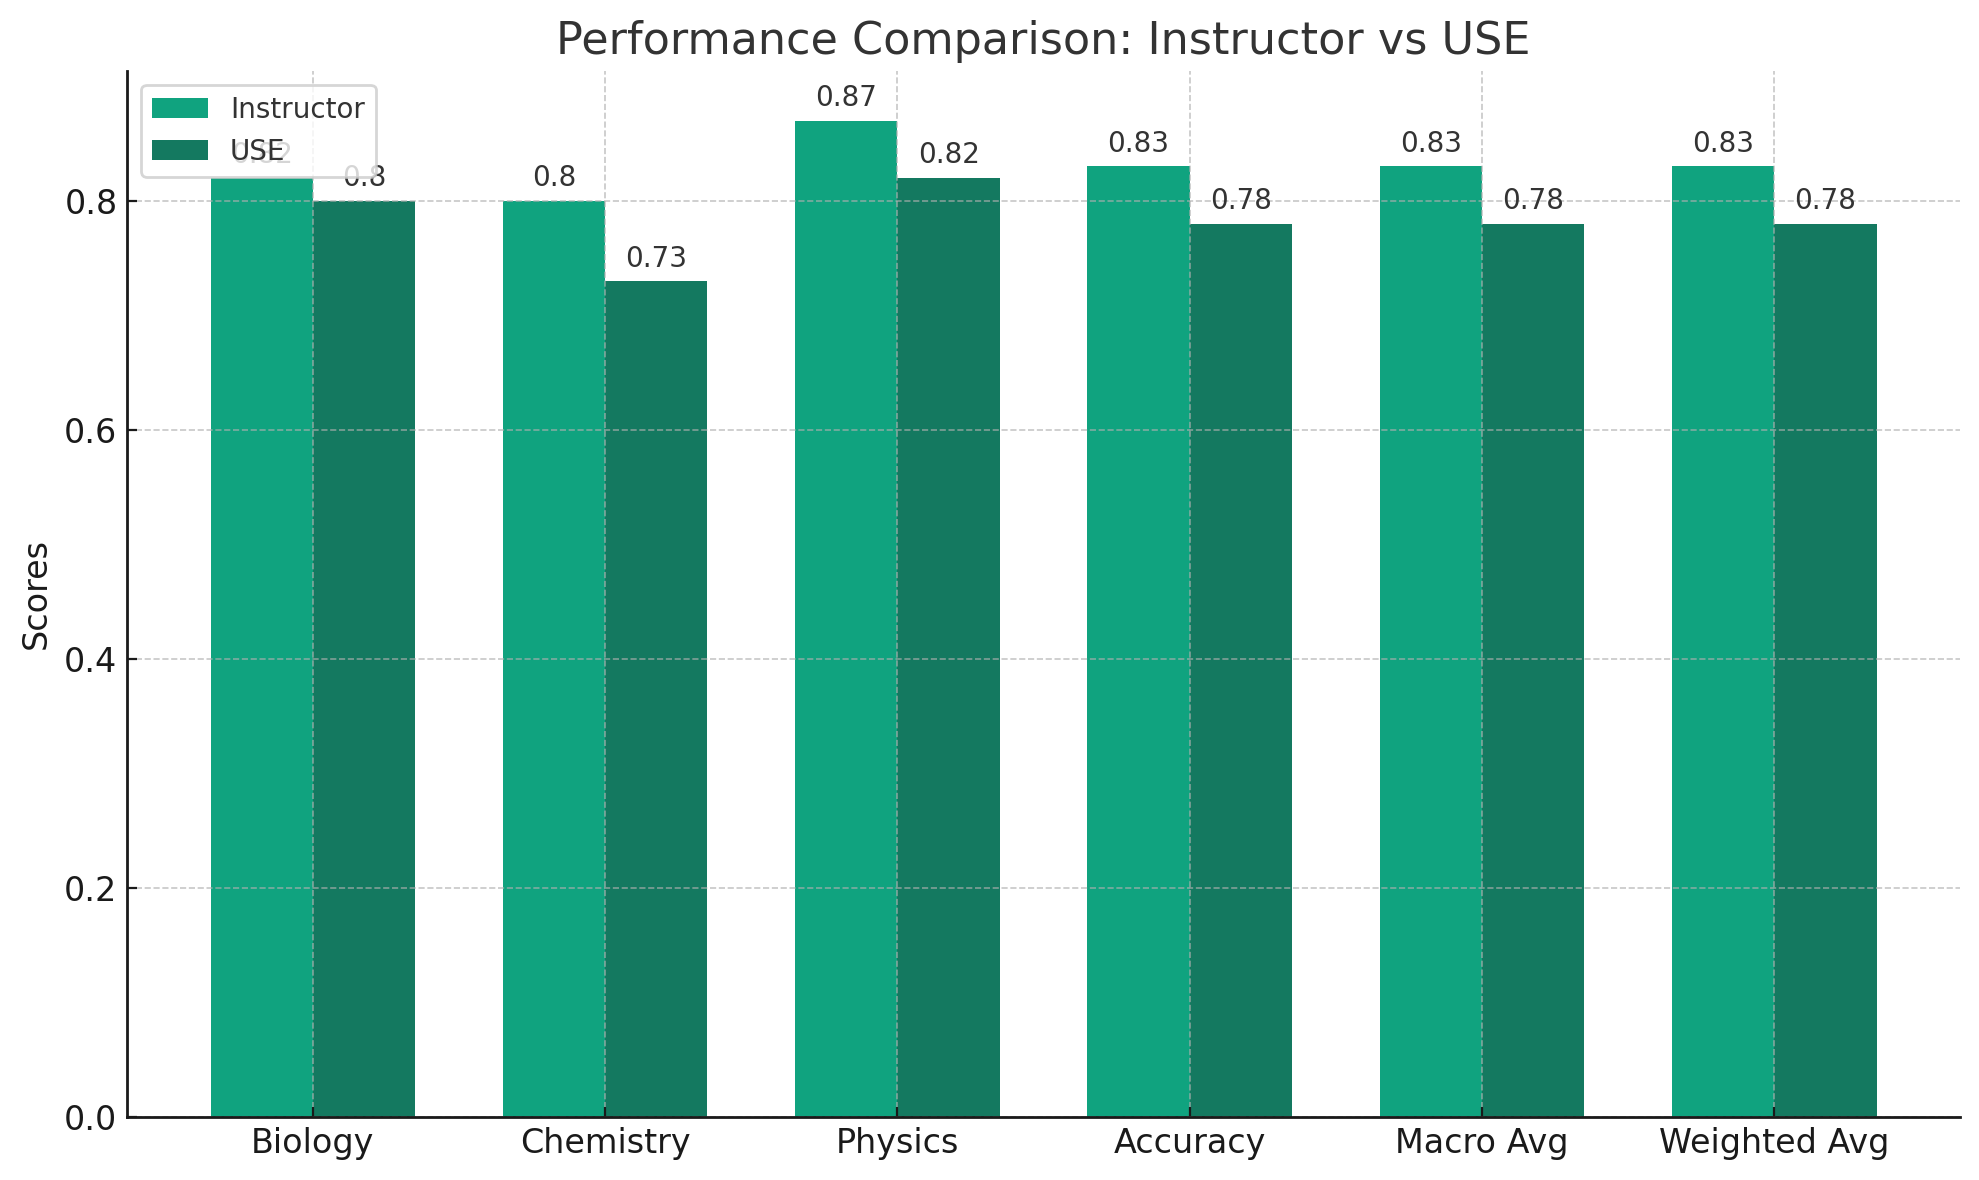

**The line graph illustrates the performance in Precision, Recall, and F1-Score for each discipline (Biology, Chemistry, Physics) and overall model performance (Accuracy, Macro Avg, Weighted Avg).**
>

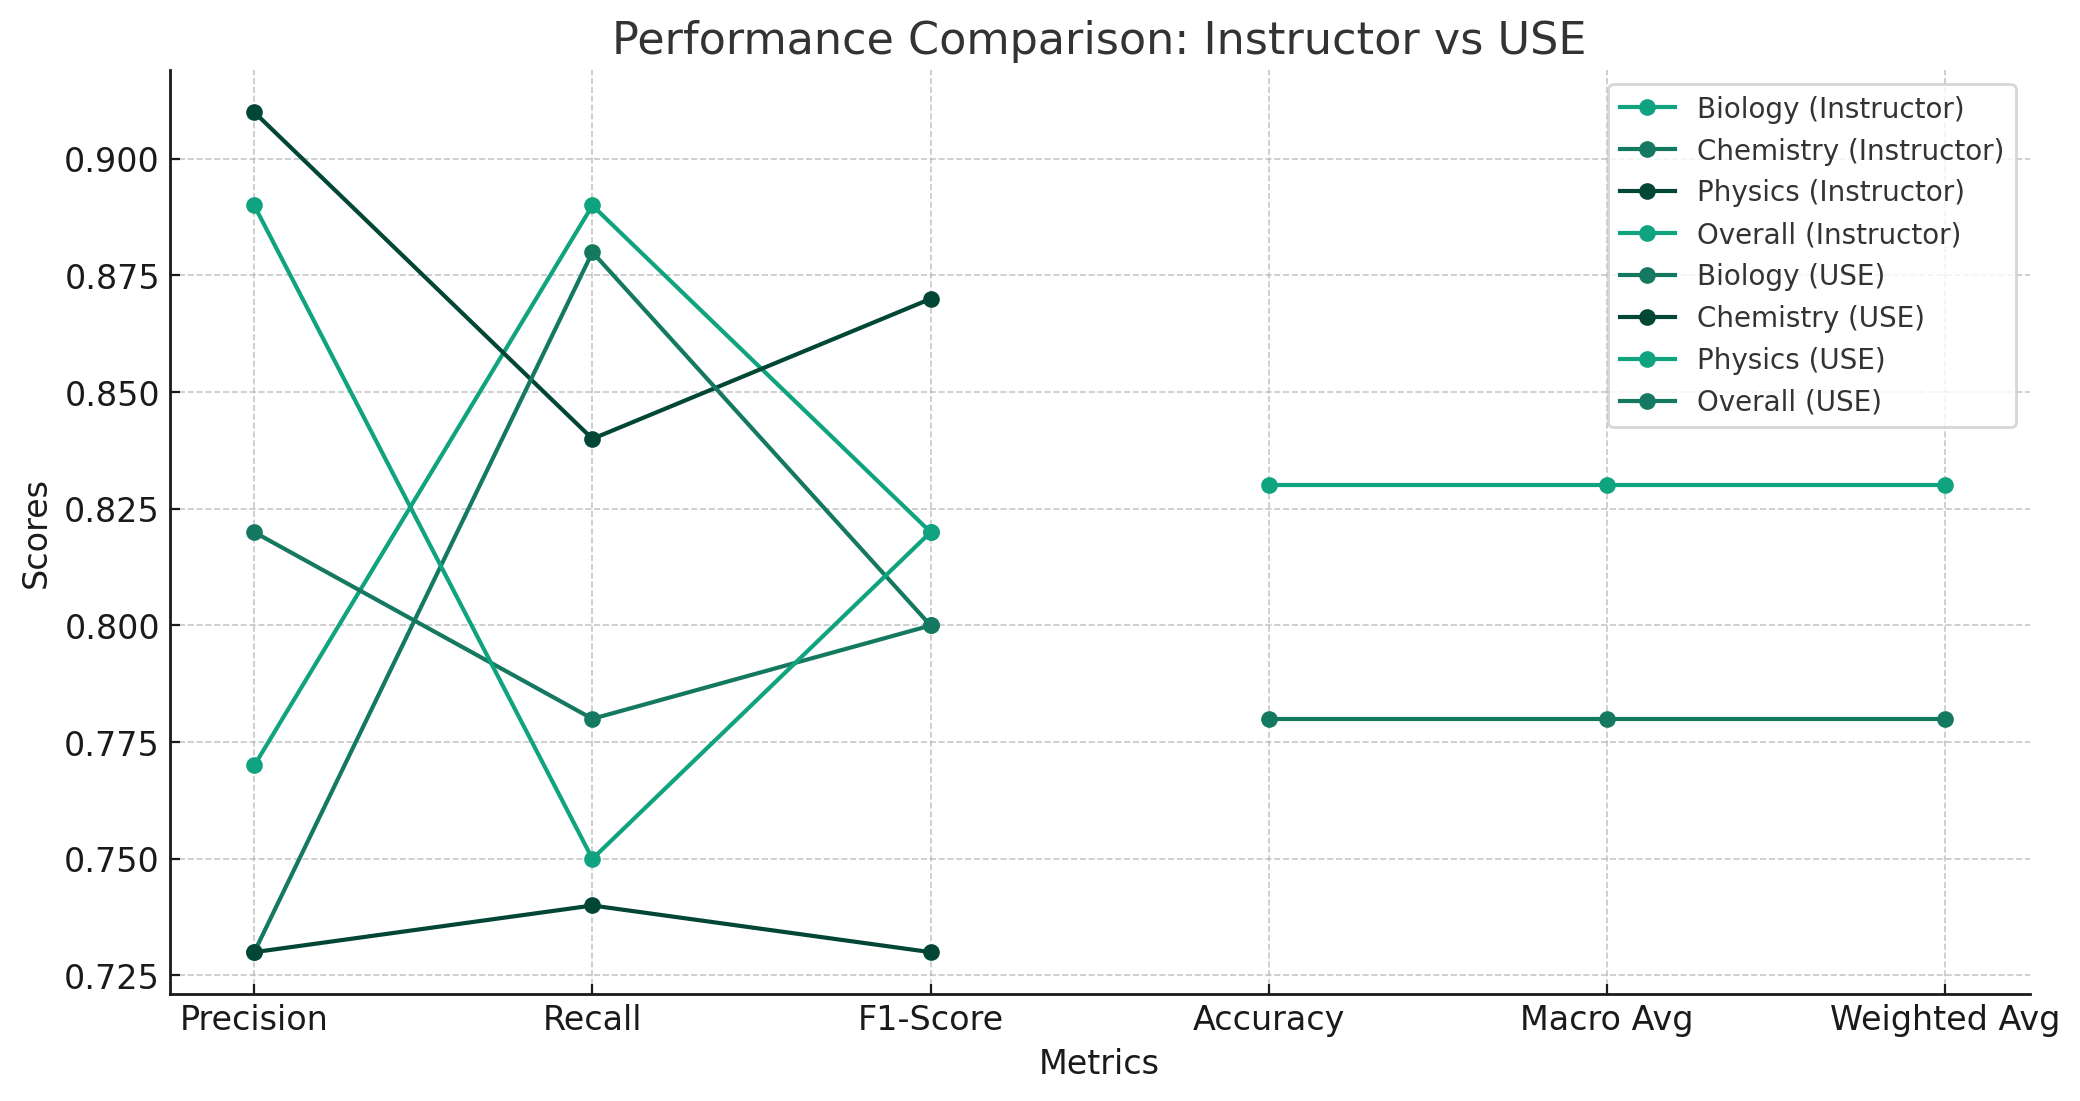